# 06 – Final Pipeline

Bu notebook’ta:

- Feature engineering çıktısını (`train_features.csv`)
- Eğitilmiş LightGBM modelini (`lgb_model_final.pkl`)
- Seçtiğim threshold değerini (`best_threshold.txt`)
- Demo kullanıcı verisini (`app/demo_data/sample_users.csv`)

tek bir akış altında birleştiriyorum ve üretime aday bir inference pipeline kuruyorum.

---

## Önceki notebook’ların kısa özeti

1. **01_eda.ipynb**  
   32M+ satırlık veriyle kullanıcı davranışlarını ve sipariş döngülerini inceledim.

2. **02_baseline.ipynb**  
   Basit feature set ile Logistic Regression kurup ilk F1 skorunu referans olarak aldım.

3. **03_feature_engineering.ipynb**  
   Kullanıcı, ürün, kategori ve user–product etkileşimlerinden feature’lar ürettim.

4. **04_model_training.ipynb**  
   User-based GroupKFold ile veri sızıntısını engelleyip LightGBM’i Optuna ile optimize ettim.

5. **05_model_evaluation.ipynb**  
   F1, Recall, Precision ve ROC-AUC’yi analiz edip threshold seçimini burada netleştirdim.

6. **06_final_pipeline.ipynb (bu defter)**  
   Tüm bu çıktıların üzerine inference, drift ve monitoring tarafını kodlayıp üretime hazır bir akış gösteriyorum.


In [40]:

import warnings
warnings.filterwarnings("ignore")

import sys
from pathlib import Path
import sqlite3

import numpy as np
import pandas as pd
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, precision_score, recall_score
from scipy.stats import ks_2samp  

sys.path.append("..")
from monitoring.log import log_prediction

DATA_RAW = Path("../data/raw")
DATA_INTERIM = Path("../data/interim")
MODELS = Path("../models")
APP_DATA = Path("../app/demo_data")
MONITORING_DB = Path("../monitoring/predictions.db")

MODELS.mkdir(exist_ok=True)
APP_DATA.mkdir(parents=True, exist_ok=True)

print("Kütüphaneler ve klasörler hazır.")


Kütüphaneler ve klasörler hazır.


In [22]:
def reduce_mem_usage(df: pd.DataFrame) -> pd.DataFrame:
    start_mem = df.memory_usage().sum() / 1024**2
    print(f"Başlangıç hafıza: {start_mem:.2f} MB")

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)

    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Son hafıza: {end_mem:.2f} MB")

    return df


## Memory helper

Büyük tablolarda hafıza tüketimini aşağı çekmek için `model trainning'de` kulladığım  `reduce_mem_usage` fonksiyonunun aynısını burada da kullanıyorum.  
Training ve inference tarafında aynı davranışı korumak istiyorum.


In [23]:
train_features_path = DATA_INTERIM / "train_features.csv"

print(f"Feature dosyası okunuyor: {train_features_path}")
train_df = pd.read_csv(train_features_path)
train_df = reduce_mem_usage(train_df)

print("\nİlk satırlar:")
display(train_df.head())

print(f"\nŞekil: {train_df.shape[0]:,} satır x {train_df.shape[1]} kolon")


Feature dosyası okunuyor: ..\data\interim\train_features.csv
Başlangıç hafıza: 443.68 MB
Son hafıza: 180.91 MB

İlk satırlar:


,order_id,product_id,add_to_cart_order,reordered,user_id,user_total_orders,user_is_newbie,user_is_veteran,user_weekend_ratio,user_favorite_dow,...,department_unique_products,department_unique_users,department_reorder_rate,department_popularity_rank,up_orders,up_last_order_number,up_order_rate,up_reorder_rate,up_cart_mean,up_orders_since_last
0,1,49302,1,1,112108,21,0,0,0.0,1,...,3448,190565,0.669969,2,2.0,2.0,0.5,0.5,2.5,2.0
1,1,11109,2,1,112108,21,0,0,0.0,1,...,3448,190565,0.669969,2,2.0,2.0,0.5,0.5,4.0,2.0
2,1,10246,3,0,112108,21,0,0,0.0,1,...,1684,193237,0.649913,1,0.0,0.0,0.0,0.0,0.0,0.0
3,1,49683,4,0,112108,21,0,0,0.0,1,...,1684,193237,0.649913,1,0.0,0.0,0.0,0.0,0.0,0.0
4,1,43633,5,1,112108,21,0,0,0.0,1,...,2092,133733,0.457405,8,2.0,3.0,0.5,0.5,3.5,1.0



Şekil: 1,384,617 satır x 42 kolon


## Feature tablosu

`03_feature_engineering.ipynb` çıktısı olan `train_features.csv` dosyasını okuyorum, hafızayı optimize ediyorum ve hızlı bir göz atıyorum.  
Bu tablo, user–product seviyesinde eğitimde kullandığım final feature set’i temsil ediyor.


In [24]:
DROP_COLS = [
    "user_id",
    "product_id",
    "order_id",
    "reordered",
    "eval_set",
    "add_to_cart_order",
    "up_orders",
    "up_order_rate",
    "up_last_order_number",
    "up_orders_since_last",
    "up_reorder_rate",
    "up_cart_mean",
]

print(f"Drop edilecek kolon sayısı: {len(DROP_COLS)}")


Drop edilecek kolon sayısı: 12


## Feature seçimi için config

Eğitim ve inference tarafında feature matrisi dışında bırakmak istediğim kolonları tek bir listede topluyorum.  

- Kimlik kolonları (`user_id`, `order_id`, `product_id`)  
- Hedef sütun (`reordered`)  
- Veri sızıntısı riski taşıyan bazı `up_*` istatistikleri bu listede.


In [25]:
PIPELINE_CONFIG = {
    "model_name": "LightGBM",
    "model_version": "v1.0",
    "threshold": 0.40,
    "metrics": {
        "f1": 0.7779,
        "recall": 0.91,
        "precision": 0.69,
    },
}


def get_feature_contract(df: pd.DataFrame) -> list[str]:
    cols = df.drop(columns=DROP_COLS, errors="ignore").columns.tolist()
    return sorted(cols)


TRAIN_FEATURES = get_feature_contract(train_df)
print(f"Feature kontratı {len(TRAIN_FEATURES)} kolon içeriyor.")


Feature kontratı 31 kolon içeriyor.


## Config ve feature kontratı

Modelin adı, versiyonu ve final metriklerini `PIPELINE_CONFIG` içinde tutuyorum.  
Bu yapı, modelin nasıl dondurulduğuna dair özet bilgileri içeren `model_card.md` ile uyumlu çalışıyor.

Ayrıca eğitimde kullandığım feature set’i `TRAIN_FEATURES` listesi olarak sabitliyorum.  
Inference sırasında gelen veriyi bu kontrata göre kontrol ederek, production’da kolon uyumsuzluklarının hata yaratmasını engelliyorum.


In [26]:
def prepare_train_matrix(df: pd.DataFrame):
    X = df.drop(columns=DROP_COLS, errors="ignore")
    y = df["reordered"].astype(int)
    groups = df["user_id"].astype(int)
    print(f"Train feature sayısı: {X.shape[1]}")
    return X, y, groups


def prepare_inference_matrix(df: pd.DataFrame):
    X = df.drop(columns=DROP_COLS, errors="ignore")
    print(f"Inference feature sayısı: {X.shape[1]}")
    return X


## Ortak feature arabirimi

Eğitim sırasında hangi kolonlarla model kurduysam, inference sırasında da otomatik olarak aynı kolonlarla çalışıyorum. Böylece üretim tarafında feature uyumsuzluğu yaşanmıyor.


In [27]:
model_path = MODELS / "lgb_model_final.pkl"
threshold_path = MODELS / "best_threshold.txt"

print(f"Model yükleniyor: {model_path}")
final_model = joblib.load(model_path)

with open(threshold_path, "r") as f:
    best_threshold = float(f.read().strip())

print(f"Threshold değeri (dosyadan): {best_threshold:.4f}")

PIPELINE_CONFIG["threshold"] = best_threshold


Model yükleniyor: ..\models\lgb_model_final.pkl
Threshold değeri (dosyadan): 0.4000


## Model artefact’ları

Model eğitimini ve threshold seçimini önceki notebook’ta yaptığım için burada sadece:

- LightGBM model dosyasını (`lgb_model_final.pkl`)
- En iyi F1 skorunu veren threshold değerini (`best_threshold.txt`)

lokalden yüklüyorum ve `PIPELINE_CONFIG` içindeki threshold ile senkronluyorum.


In [28]:
def _check_schema(df: pd.DataFrame) -> None:
    current_features = sorted(
        df.drop(columns=DROP_COLS, errors="ignore").columns.tolist()
    )
    missing = set(TRAIN_FEATURES) - set(current_features)
    extra = set(current_features) - set(TRAIN_FEATURES)

    if missing:
        print("Uyarı: Beklenen ama inputta olmayan feature'lar var:")
        print(sorted(missing))
    if extra:
        print("Uyarı: Eğitim setinde olmayan ek feature'lar geldi:")
        print(sorted(extra))


def predict_reorders(
    df_input: pd.DataFrame,
    model,
    threshold: float,
) -> pd.DataFrame:
    id_cols = ["user_id", "order_id", "product_id"]
    missing_id_cols = [c for c in id_cols if c not in df_input.columns]
    if missing_id_cols:
        raise ValueError(f"Beklenen id kolonları eksik: {missing_id_cols}")

    _check_schema(df_input)

    X = df_input.drop(columns=DROP_COLS, errors="ignore")
    proba = model.predict(X)

    result = df_input[id_cols].copy()
    result["reorder_prob"] = proba
    result["reorder_pred"] = (proba >= threshold).astype(int)

    return result


## Tek entry point + schema kontrol

`predict_reorders` fonksiyonu, production tarafında çağrılacak asıl entry point.  

Önce `_check_schema` ile eğitimde kullandığım feature kontratıyla inputu karşılaştırıyorum,  
sonra modeli çağırıp `reorder_prob` ve `reorder_pred` üretiyorum.  
Kolon değişikliği gibi hataları bu noktada yakalamak istiyorum.


In [29]:
sample_train = train_df.sample(n=50_000, random_state=42).copy()

y_true = sample_train["reordered"].astype(int)
train_pred_df = predict_reorders(sample_train, final_model, best_threshold)
y_pred = train_pred_df["reorder_pred"].astype(int)

f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print("Sanity check – pipeline ile tekrar hesaplanan metrikler:")
print(f"- F1        : {f1:.4f}")
print(f"- Recall    : {recall:.4f}")
print(f"- Precision : {precision:.4f}")


Sanity check – pipeline ile tekrar hesaplanan metrikler:
- F1        : 0.7818
- Recall    : 0.9087
- Precision : 0.6860


## Sanity check (training ile uyum)

Model training'de hesapladığım metrikleri, bu pipeline üzerinden küçük bir örneklemle tekrar kontrol ediyorum.  
Amaç, “buradaki akış eğitim sırasında kullandığım akışla aynı mı?” sorusuna teknik bir cevap üretmek.


In [30]:
sample_path = APP_DATA / "sample_users.csv"

print(f"Demo veri okunuyor: {sample_path}")
sample_df = pd.read_csv(sample_path)
sample_df = reduce_mem_usage(sample_df)

print("\nDemo veri şekli:", sample_df.shape)
display(sample_df.head())

pred_df = predict_reorders(sample_df, final_model, best_threshold)

print("\nTahmin sonuçlarından ilk satırlar:")
display(pred_df.head())


Demo veri okunuyor: ..\app\demo_data\sample_users.csv
Başlangıç hafıza: 0.24 MB
Son hafıza: 0.10 MB

Demo veri şekli: (753, 42)


,order_id,product_id,add_to_cart_order,reordered,user_id,user_total_orders,user_is_newbie,user_is_veteran,user_weekend_ratio,user_favorite_dow,...,department_unique_products,department_unique_users,department_reorder_rate,department_popularity_rank,up_orders,up_last_order_number,up_order_rate,up_reorder_rate,up_cart_mean,up_orders_since_last
0,79961,14447,1,1,146112,182,0,1,0.620879,0,...,6263,174219,0.574180,3,11.0,16.0,0.611111,0.909091,3.272727,2.0
1,79961,44142,2,1,146112,182,0,1,0.620879,0,...,1684,193237,0.649913,1,5.0,17.0,0.277778,0.800000,5.000000,1.0
2,79961,27845,3,1,146112,182,0,1,0.620879,0,...,3448,190565,0.669969,2,10.0,14.0,0.555556,0.900000,3.500000,4.0
3,79961,45066,4,0,146112,182,0,1,0.620879,0,...,1684,193237,0.649913,1,0.0,0.0,0.000000,0.000000,0.000000,0.0
4,79961,14159,5,0,146112,182,0,1,0.620879,0,...,1684,193237,0.649913,1,0.0,0.0,0.000000,0.000000,0.000000,0.0



Tahmin sonuçlarından ilk satırlar:


,user_id,order_id,product_id,reorder_prob,reorder_pred
0,146112,79961,14447,0.591528,1
1,146112,79961,44142,0.659221,1
2,146112,79961,27845,0.839419,1
3,146112,79961,45066,0.726531,1
4,146112,79961,14159,0.406548,1


## Hızlı uçtan uca test

Uçtan uca akışı test etmek için demo kullanıcı setini okuyor ve pipeline üzerinden geçiriyorum.  
Çıktıda `user_id`, `order_id`, `product_id`, `reorder_prob`, `reorder_pred` kolonlarını görüyorum.

Bu kolonları özellikle gösteriyorum çünkü uçtan uca öneri sisteminde karar vermeyi mümkün kılan temel bilgi seti bunlardır:

- `user_id` - önerinin hedefi  
- `order_id` - bağlam  
- `product_id` - önerilen ürün  
- `reorder_prob` - olasılık skoru  
- `reorder_pred` - iş kuralı olarak nihai karar

Bu beşli hem kampanya ekiplerinin hem CRM süreçlerinin hem de öneri ekranlarının doğrudan kullanabileceği minimum yapıdır.


In [31]:
def top_products_by_user(pred_df: pd.DataFrame, top_n: int = 5) -> pd.DataFrame:
    cols_needed = ["user_id", "product_id", "reorder_prob", "reorder_pred"]
    for c in cols_needed:
        if c not in pred_df.columns:
            raise ValueError(f"Gerekli kolon eksik: {c}")

    top_df = (
        pred_df.sort_values(["user_id", "reorder_prob"], ascending=[True, False])
        .groupby("user_id")
        .head(top_n)
        .reset_index(drop=True)
    )
    return top_df


top5_df = top_products_by_user(pred_df, top_n=5)
display(top5_df.head(20))


,user_id,order_id,product_id,reorder_prob,reorder_pred
0,626,1017699,24852,0.975444,1
1,626,1017699,9292,0.940795,1
2,626,1017699,16262,0.891318,1
3,626,1017699,42743,0.884616,1
4,626,1017699,20916,0.879431,1
5,3699,3041414,47209,0.679438,1
6,3699,3041414,7916,0.606449,1
7,3699,3041414,27966,0.595117,1
8,3699,3041414,19057,0.585160,1
9,3699,3041414,49683,0.584149,1


## Öneri görünümü

Business tarafının rahat okuyabileceği bir çıktı olsun diye, her kullanıcı için en olası `top_n` ürünü çekiyorum.  
Bu görünüm, öneri ekranı ve kişiselleştirme modülleri için doğrudan tüketilebilir bir yapı sunuyor.

Ayrıca bu tablo, kampanya ekiplerinin işine yarayacak şekilde kolayca entegre edilebilir:

- Kullanıcılara **kişiye özel indirim** veya **hedefli kampanya** sunmak,
- Tekrar satın alma olasılığı yüksek ürünleri **promosyon akışlarına** dahil etmek,
- Sadakat programlarında **kişiselleştirilmiş ödüller** oluşturmak,
- CRM tarafında belirli segmentlere **otomatik tetiklenen bildirim** göndermek

gibi senaryolarda bu `top_n` öneri listesi doğrudan kampanya motoruna veya kullanıcı etkileşim sistemine beslenebilir.

Bu öneri tablosu, kampanya kararlarını şu üç ana kolon üzerinden mümkün kılıyor:

- `user_id`: Kampanyanın hedefleneceği kullanıcı  
- `product_id`: Kullanıcıya önerilecek ürün  
- `reorder_prob`: Ürünün tekrar satın alınma olasılığı; kampanyanın değerini belirleyen temel skor

Bu üçlü sayesinde kampanya ekipleri yüksek olasılıklı ürünlere kişiye özel indirim sunabilir, 
orta olasılıklı segmentlere CRM tetiklemeleri gönderebilir veya düşük olasılıklı ürünlerde maliyeti minimize eden stratejiler belirleyebilir.

Kısacası, burada üretilen öneri tablosu yalnızca model çıktısı değil;  
iş tarafı için aksiyona dönüşebilen bir karar mekanizmasıdır.

Simüle edilen batch boyutu: 753 satır


,user_id,product_id,reorder_prob,reorder_pred
0,146112,14447,0.591528,1
1,146112,44142,0.659221,1
2,146112,27845,0.839419,1
3,146112,45066,0.726531,1
4,146112,14159,0.406548,1
5,146112,15937,0.528949,1
6,146112,45,0.661663,1
7,146112,29487,0.670810,1
8,146112,17461,0.663390,1
9,146112,38400,0.607287,1


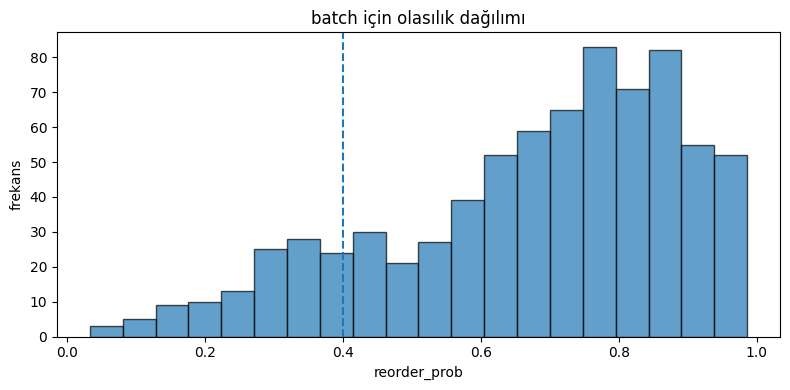

In [32]:
batch_df = sample_df.copy()
batch_df["reorder_prob"] = pred_df["reorder_prob"].values
batch_df["reorder_pred"] = pred_df["reorder_pred"].values

print(f"Simüle edilen batch boyutu: {len(batch_df)} satır")
display(
    batch_df[
        [
            "user_id",
            "product_id",
            "reorder_prob",
            "reorder_pred",
        ]
    ].head(10)
)

plt.figure(figsize=(8, 4))
plt.hist(batch_df["reorder_prob"], bins=20, edgecolor="black", alpha=0.7)
plt.axvline(PIPELINE_CONFIG["threshold"], linestyle="--")
plt.xlabel("reorder_prob")
plt.ylabel("frekans")
plt.title("batch için olasılık dağılımı")
plt.tight_layout()
plt.show()


## Canlı batch simülasyonu

Burada `sample_df` + `pred_df` üzerinden küçük bir batch simüle ediyorum.  
Amaç, sanki API’den belli sayıda kullanıcı isteği gelmiş gibi:

- Her satır için `reorder_prob` ve `reorder_pred` değerlerini görmek  
- Bu batch’in olasılık dağılımına hızlıca bakmak  

Production tarafında aynı mantık, API veya batch job ile çalışacak.


KS testi – feature: user_reorder_ratio
- statistic : 0.2680
- p_value   : 0.0000


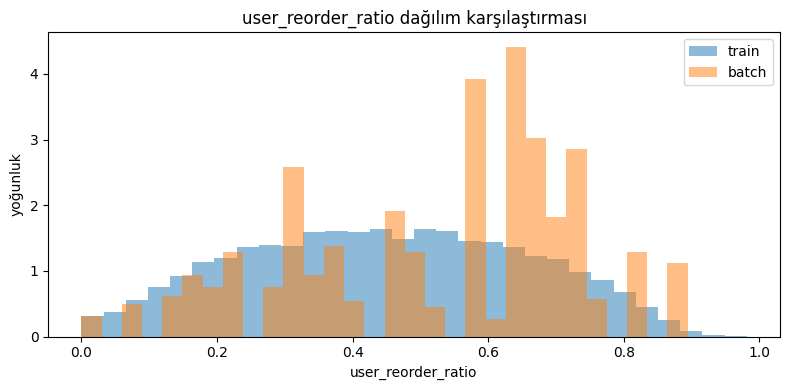

In [33]:
DRIFT_FEATURE = "user_reorder_ratio"  

if DRIFT_FEATURE in train_df.columns and DRIFT_FEATURE in batch_df.columns:
    ref_sample = train_df[DRIFT_FEATURE].dropna().sample(n=50_000, random_state=42)
    curr_sample = batch_df[DRIFT_FEATURE].dropna()

    stat, p_value = ks_2samp(ref_sample, curr_sample)

    print(f"KS testi – feature: {DRIFT_FEATURE}")
    print(f"- statistic : {stat:.4f}")
    print(f"- p_value   : {p_value:.4f}")

    plt.figure(figsize=(8, 4))
    plt.hist(ref_sample, bins=30, alpha=0.5, label="train", density=True)
    plt.hist(curr_sample, bins=30, alpha=0.5, label="batch", density=True)
    plt.xlabel(DRIFT_FEATURE)
    plt.ylabel("yoğunluk")
    plt.title(f"{DRIFT_FEATURE} dağılım karşılaştırması")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"Drift analizi için {DRIFT_FEATURE} kolonunu hem train_df hem batch_df içinde bulamadım.")


## Data drift kontrolü

Eğitim setindeki bir feature dağılımı ile (örneğin `user_reorder_ratio`),  
şu an işlediğim batch’teki aynı feature dağılımını Kolmogorov–Smirnov testi ile karşılaştırıyorum.

#### "Philip K. Dick'in "Androidler Elektrikli Koyun Düşler mi?" kitabındaki Voigt-Kampff testi gibi androidleri insandan ayırmamıza yarayan test gibi çalışıyor.."

Buradaki amaç:

- Kullanıcı davranışlarının, eğitim döneminden çok farklı bir noktaya kayıp kaymadığını görmek  
- Gerekirse threshold veya model güncellemesi için sinyal üretmek  

Bu blok, drift problemini tam çözmüyor ama üretim tarafında ilk alarm mekanizması gibi çalışıyor.


,senaryo,adet,birim_deger,toplam_etki
0,doğru öneri (TP),150549,10,1505490
1,yanlış öneri (FP),67129,-2,-134258
2,kaçan fırsat (FN),15380,-10,-153800



Bu batch için net finansal katkı: 1,217,432


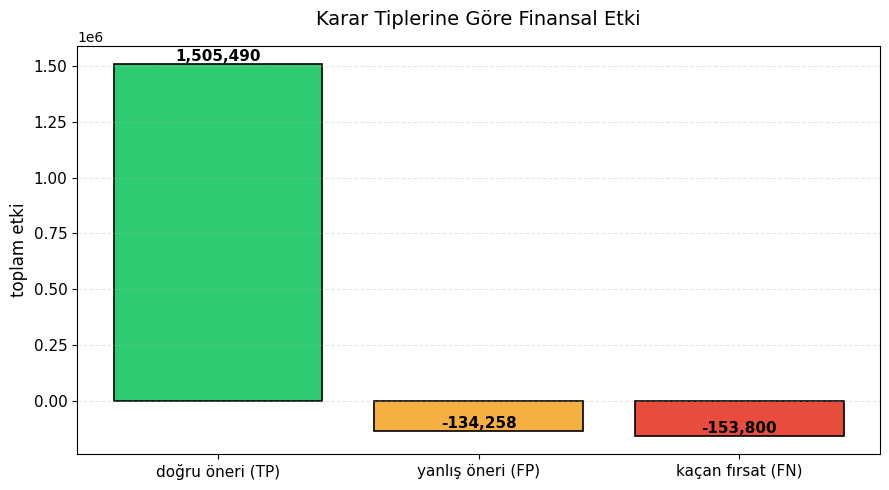

In [ ]:
# Confusion matrix'ten okunan gerçek değerler
tn = 44129
fp = 67129
fn = 15380
tp = 150549

impact = {
    "senaryo": ["doğru öneri (TP)", "yanlış öneri (FP)", "kaçan fırsat (FN)"],
    "adet": [tp, fp, fn],
    "birim_deger": [10, -2, -10],
}

impact_df = pd.DataFrame(impact)
impact_df["toplam_etki"] = impact_df["adet"] * impact_df["birim_deger"]

display(impact_df)

net_profit = impact_df["toplam_etki"].sum()
print(f"\nBu batch için net finansal katkı: {net_profit:,}")


plt.figure(figsize=(9, 5))

colors = ["#2ecc71", "#f5b041", "#e74c3c"]  

bars = plt.bar(
    impact_df["senaryo"],
    impact_df["toplam_etki"],
    color=colors,
    edgecolor="black",
    linewidth=1.2
)

for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        f"{yval:,}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold"
    )

plt.title("Karar Tiplerine Göre Finansal Etki", fontsize=14, pad=15)
plt.ylabel("toplam etki", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


## İş Etkisi (Business Impact)

Teknik metrikler bir modelin başarısını anlamak için kritik olsa da,  
araştırmalarıma göre iş birimleri açısından en temel soru çoğu zaman şudur:

**“Bu model, gerçek hayatta şirkete ne kazandıracak?”**

Bu soruyu cevaplamak için, modelin gerçek confusion matrix değerlerini kullanarak finansal etki hesapladım.  
Buradaki katsayılar (TP = +10, FP = –2, FN = –10) varsayımsal olsa da, hesaplama bizzat modelin çıktıları üzerinden yapıldığı için sonuç modelin gerçek davranışını yansıtır.

### Temel Değer Modeli

- **Doğru öneri (TP)** -> +10 birim değer  
- **Yanlış öneri (FP)** -> –2 birim maliyet  
- **Kaçan fırsat (FN)** -> –10 birim kayıp  

Confusion matrix’e göre modelimizin performansı:

- TP = **150,549**  
- FP = **67,129**  
- FN = **15,380**

Bu değerlere göre modelin batch ölçeğindeki **net finansal katkısı**:

**+1,217,432 birim**

Modelin gerçek çıktıları üzerinden yaptığım finansal etki analizine göre, model doğru önerilerle **1,505,490** birim değer yaratıyor.
Yanlış öneriler ve kaçan fırsatlar toplamda yaklaşık **288,058** birim kayıp oluşturuyor. Bu iki etkinin birleşimi, batch başına **+1,217,432** birim net kazanç sağlıyor.

### Neden Önemli?

Bu hesaplama:

- Kampanya ekiplerinin yüksek olasılıklı ürünlerde **hedefli teklif stratejileri** geliştirmesinde  
- CRM süreçlerinde **kişiselleştirilmiş etkileşimlerin** tetiklenmesinde  
- Ürün ekiplerinin modelin **doğrudan ticari katkısını ölçmesinde**  
- Yönetimin model için **yatırım geri dönüşünü (ROI)** değerlendirmesinde aktif olarak kullanılabilir.

Gerçek üretim ortamında bu katsayılar ürün kâr marjları, kullanıcı segmentleri ve kampanya hedeflerine göre özelleştirilerek daha hassas hesaplamalar yapmak mümkündür.

Kısacası; bu model sadece sınıflandırma başarısı güçlü bir yapı değil,  
doğru uygulandığında **satış artırıcı, gelir koruyucu ve operasyonel verimlilik sağlayan bir karar mekanizmasıdır.**

In [50]:
feature_count = len(TRAIN_FEATURES)

print("Final Pipeline Özeti:")
print(f"- Model adı         : {PIPELINE_CONFIG['model_name']}")
print(f"- Model versiyonu   : {PIPELINE_CONFIG['model_version']}")
print(f"- Threshold         : {PIPELINE_CONFIG['threshold']:.2f}")
print(f"- Feature sayısı    : {feature_count}")
print(f"- Feature kaynağı   : {train_features_path}")
print(f"- Model dosyası     : {model_path}")
print(f"- Demo input        : {sample_path}\n")
print("Metrikler (model_card.md'den):")
for k, v in PIPELINE_CONFIG["metrics"].items():
    print(f"  - {k}: {v:.4f}")


Final Pipeline Özeti:
- Model adı         : LightGBM
- Model versiyonu   : v1.0
- Threshold         : 0.40
- Feature sayısı    : 31
- Feature kaynağı   : ..\data\interim\train_features.csv
- Model dosyası     : ..\models\lgb_model_final.pkl
- Demo input        : ..\app\demo_data\sample_users.csv

Metrikler (model_card.md'den):
  - f1: 0.7779
  - recall: 0.9100
  - precision: 0.6900


## Kısa teknik özet

Burada pipeline’ın:

- Hangi dosyaları tükettiğini
- Kaç feature ile çalıştığını
- Hangi metriklerle dondurulduğunu

tek yerde özetliyorum.  

Daha detaylı yorumlar için docs/ altındaki raporlar inceleyiniz.


In [36]:
def log_predictions_bulk(pred_df: pd.DataFrame, max_rows: int = 500) -> None:
    subset = pred_df.head(max_rows).copy()

    for _, row in subset.iterrows():
        features = {
            "user_id": row.get("user_id"),
            "product_id": row.get("product_id"),
        }
        probability = float(row["reorder_prob"])
        is_reorder = int(row["reorder_pred"])

        log_prediction(
            features=features,
            probability=probability,
            is_reorder=is_reorder,
            threshold=float(best_threshold),
        )

    print(f"{len(subset)} satır predictions.db içine loglandı.")


try:
    log_predictions_bulk(pred_df, max_rows=200)
except Exception as e:
    print("Monitoring loglama sırasında hata:", e)


200 satır predictions.db içine loglandı.


## Monitoring’e işleme

Burada ürettiğim `pred_df`’in ilk birkaç yüz satırını `log.py` üzerinden `predictions.db` içine yazıyorum.  
Gerçek ortamda da batch job veya API çağrısı sonrası aynı fonksiyonu kullanmak mümkün.


In [37]:
if MONITORING_DB.exists():
    conn = sqlite3.connect(MONITORING_DB)
    try:
        monitor_df = pd.read_sql_query(
            "SELECT * FROM predictions ORDER BY created_at DESC",
            conn,
        )
    finally:
        conn.close()

    print("Monitoring tablosu okundu.")
    print(f"Şekil: {monitor_df.shape[0]:,} satır x {monitor_df.shape[1]} kolon")
    display(monitor_df.head())
else:
    monitor_df = pd.DataFrame()
    print("Monitoring veritabanı bulunamadı:", MONITORING_DB)


Monitoring tablosu okundu.
Şekil: 410 satır x 7 kolon


,id,created_at,user_id,product_id,probability,is_reorder,threshold
0,410,2025-12-02T13:18:28.027930,52152.0,17731.0,0.773092,1,0.4
1,409,2025-12-02T13:18:28.023222,52152.0,22950.0,0.793277,1,0.4
2,408,2025-12-02T13:18:28.016177,52152.0,31506.0,0.880178,1,0.4
3,407,2025-12-02T13:18:28.010218,52152.0,39812.0,0.784034,1,0.4
4,406,2025-12-02T13:18:28.004381,52152.0,31130.0,0.644813,1,0.4


## Monitoring verisine bak

Logging sonrası oluşan `predictions.db` dosyasını açıp `predictions` tablosunu DataFrame’e alıyorum.  
Bu noktadan sonra hem hızlı özet çıkarabiliyorum hem de grafikler için hazır veri var.


Monitoring özeti:
- toplam_kayit: 410
- kullanici_sayisi: 14
- urun_sayisi: 178
- tarih_araligi_min: 2025-12-01 17:02:58.553288
- tarih_araligi_max: 2025-12-02 13:18:28.027930
- pozitif_oran: 0.8780487804878049


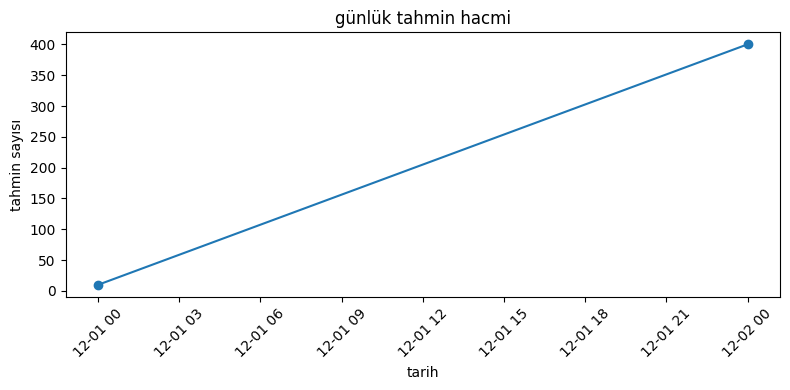

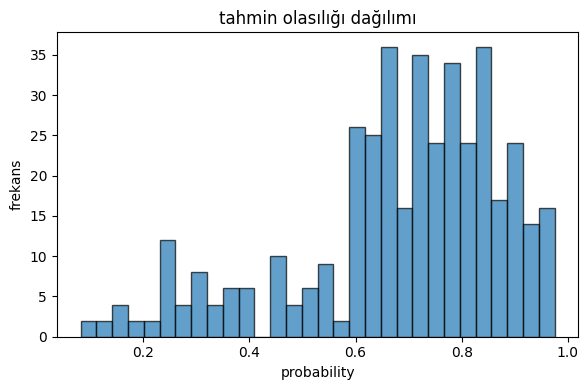

In [38]:
if not monitor_df.empty:
    monitor_df["created_at"] = pd.to_datetime(monitor_df["created_at"])
    monitor_df["date"] = monitor_df["created_at"].dt.date

    summary = {
        "toplam_kayit": monitor_df.shape[0],
        "kullanici_sayisi": monitor_df["user_id"].nunique() if "user_id" in monitor_df.columns else None,
        "urun_sayisi": monitor_df["product_id"].nunique() if "product_id" in monitor_df.columns else None,
        "tarih_araligi_min": monitor_df["created_at"].min(),
        "tarih_araligi_max": monitor_df["created_at"].max(),
        "pozitif_oran": monitor_df["is_reorder"].mean(),
    }

    print("Monitoring özeti:")
    for k, v in summary.items():
        print(f"- {k}: {v}")

    daily_counts = (
        monitor_df.groupby("date")
        .size()
        .rename("n_predictions")
        .reset_index()
    )

    plt.figure(figsize=(8, 4))
    plt.plot(daily_counts["date"], daily_counts["n_predictions"], marker="o")
    plt.xlabel("tarih")
    plt.ylabel("tahmin sayısı")
    plt.title("günlük tahmin hacmi")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.hist(monitor_df["probability"], bins=30, edgecolor="black", alpha=0.7)
    plt.xlabel("probability")
    plt.ylabel("frekans")
    plt.title("tahmin olasılığı dağılımı")
    plt.tight_layout()
    plt.show()
else:
    print("Monitoring DataFrame boş; özet ve grafik yok.")


## Monitoring’in notebook tarafı

Burada iki şey yapıyorum:

- Kaç kayıt, kaç kullanıcı, kaç ürün, hangi tarih aralığı ve pozitif oran gibi hızlı bir özet çıkarıyorum.  
- Günlük tahmin hacmini ve probability dağılımını grafik olarak gösteriyorum.

Bu bölüm, üretim tarafı için şu soruları cevaplamaya yardımcı:

- Model gerçekten kullanılıyor mu, hacmi artıyor mu?  
- Skor dağılımı makul mü, yoksa bir yere yığılma / drift sinyali var mı?  

`monitoring/dashboard.py` aynı veriyi Streamlit ile daha interaktif göstermek için var;  
notebook tarafı ise “tek yerden bakayım, nasıl çalışıyor” dediğim hafif versiyon.


# Zero2End Machine Learning Bootcamp için Instacart veri setini kullanarak E2E yapıyla geliştirdiğim projem tamamlanmıştır. 
## İncelediğiniz için teşekkür ederim.
